<a href="https://colab.research.google.com/github/ayami-n/Flax_text_prediction/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Flax_text_prediction

/content/drive/MyDrive/Flax_text_prediction


# Import libs

In [ ]:
%%capture
!pip install git+https://github.com/huggingface/transformers.git
!pip install flax
!pip install git+https://github.com/deepmind/optax.git

In [ ]:
import jax
from jax import random  # to create random values for initalizing a model (Flax requires)
import jax.numpy as jnp

# Flax for building model
try:
    import flax
except ModuleNotFoundError: # Install flax if missing
    !pip install --quiet flax
    import flax
    
from flax import linen as nn
from flax.training import train_state, checkpoints
from flax.core.frozen_dict import freeze, unfreeze
from flax import traverse_util

# Optax for optimizor 
import optax

# Transformers
!pip install transformers
from transformers import FlaxAutoModelForSequenceClassification, RobertaTokenizer, RobertaConfig # as we use Roberta model
from transformers.modeling_flax_utils import FlaxPreTrainedModel  # FlaxMLPModule is still stateless

# others
import pandas as pd
from tqdm import tqdm
from typing import Callable, Any
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import numpy as np
!pip install datasets
from datasets import load_dataset

     |████████████████████████████████| 202 kB 5.1 MB/s 
     |████████████████████████████████| 145 kB 54.5 MB/s 
     |████████████████████████████████| 9.1 MB 27.5 MB/s 
     |████████████████████████████████| 596 kB 50.3 MB/s 
     |████████████████████████████████| 217 kB 39.4 MB/s 
     |████████████████████████████████| 51 kB 5.1 MB/s 
     |████████████████████████████████| 72 kB 483 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 4.4 MB/s 
     |████████████████████████████████| 101 kB 10.2 MB/s 
     |████████████████████████████████| 6.6 MB 34.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 365 kB 5.2 MB/s 
     |████████████████████████████████| 1.1 MB 52.7 MB/s 
     |████████████████████████████████| 140 kB 67.9 MB/s 
     |████████████████████████████████| 212 kB 60.7 MB/

In [ ]:
print("TPU: ", jax.local_devices())

TPU:  [CpuDevice(id=0)]


# Config

In [ ]:
### Model Config ####
model_checkpoint = 'siebert/sentiment-roberta-large-english' # https://huggingface.co/docs/transformers/model_doc/roberta#roberta
seed = 0  # for building our model

tokenizer = RobertaTokenizer.from_pretrained(model_checkpoint)  # this tokenizer converts numeric from string: the values are different if you select different model_checkpoint

### Train Config ####
num_train_epochs = 5
learning_rate = 2e-5
per_device_batch_size = 32
weight_decay=1e-2
total_batch_size = per_device_batch_size * jax.local_device_count()

# Tokenaization and Loading Data

In [ ]:
'''
https://stackoverflow.com/questions/65246703/how-does-max-length-padding-and-truncation-arguments-work-in-huggingface-bertt
adding [CLS] token at the beginning of the sentence, and [SEP] token at the end of sentence.
[CLS] I love you [SEP] is expected by BERT. 
tokenizer gives [CLS] and [SEP] usually
'''

## Data Analysis

In [ ]:
df = pd.read_csv("./kaggle/train.csv")  # import train datasets
max = 0
max_str = "Who is Max?"
words_list = []

for itr, val in enumerate(df['discourse_text'].to_numpy()):
  words = val.split()
  words_list.append(len(words))

  if len(words) > max:
    max = len(words)
    max_str = val

print(pd.Series(list(filter(lambda x: (x <= 256), words_list))).count(), len(words_list))    

36566 36765


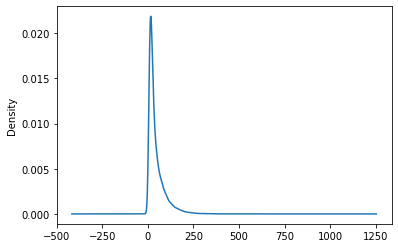

In [ ]:
'''
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.plot.kde.html
'''
pd.Series(words_list).plot.kde()  # most words are less than 250

## Creating Dummy Inputs

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.05, random_state=seed)  # spliting datasets 95% train and 5% val

max_len = 256  # input text should be the same length (most words <= 256)

dummy = tokenizer(train_df['discourse_text'].to_numpy()[:1][0], # [:1][0] -> makes str
                  max_length=max_len, truncation=True, 
                  padding='max_length', 
                  return_tensors='jax') # add_special_tokens=True is default: truncation=True is cutting off longer sentences (longer than max_length)

dummy_input_ids, dummy_attention_mask = dummy['input_ids'], dummy['attention_mask']  # jax: the values (text) are converted by the tokenizer, the values (attention-mask) are converted by the tokenizer

In [ ]:
tokenizer.convert_ids_to_tokens(dummy_input_ids.squeeze())[:30]  # checking the converted id's

## Loading Data

In [ ]:
data = load_dataset("csv", data_files={'train': "./kaggle/train.csv"})
data = data["train"].train_test_split(0.05)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-cb7c2ac4769ea286/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
def preprocess_function(input_batch):
   
    texts = (input_batch["discourse_text"],)
    processed = tokenizer(*texts, 
                          max_length=256, 
                          truncation=True, padding='max_length', 
                          return_tensors='np')     
    
    # replace label -> numerical
    processed["labels"] = input_batch["discourse_effectiveness"]
    new_label = {"Ineffective": 0, "Adequate": 1, "Effective": 2}
    processed["labels"] = [x if x not in new_label else new_label[x] for x in processed["labels"]]
    
    return processed

In [ ]:
tokenized_dataset = data.map(preprocess_function, batched=True, remove_columns=data["train"].column_names)
train_dataset = tokenized_dataset["train"]
validation_dataset = tokenized_dataset["test"]

  0%|          | 0/35 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [ ]:
def train_data_loader(rng, dataset, batch_size):
    steps_per_epoch = len(dataset) // batch_size  # 32/(32*8)
    perms = jax.random.permutation(rng, len(dataset))  # shuffle
    perms = perms[: steps_per_epoch * batch_size]  # Skip incomplete batch.
    perms = perms.reshape((steps_per_epoch, batch_size))

    for perm in perms:
        batch = dataset[perm]
        batch = {k: jnp.array(v) for k, v in batch.items()}  # stack values
        # batch = shard(batch) # for TPU
        yield batch  

In [ ]:
def eval_data_loader(dataset, batch_size): 
    for i in range(len(dataset) // batch_size):
        batch = dataset[i * batch_size : (i + 1) * batch_size]
        batch = {k: jnp.array(v) for k, v in batch.items()}  # stack values
        # batch = shard(batch)  # for TPU 
        yield batch

# Create a model

In [ ]:
# the model size is 1.32G
pretrained_roberta = FlaxAutoModelForSequenceClassification.from_pretrained(model_checkpoint, seed=seed)  

Downloading:   0%|          | 0.00/1.32G [00:00<?, ?B/s]

In [ ]:
class MyNLP(nn.Module):
    roberta: nn.Module

    @nn.compact
    def __call__(self, input_ids, attention_mask, train=True, dropout_rng=None):  # https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/ 
        out = self.roberta(input_ids, attention_mask, output_hidden_states=True, dropout_rng=dropout_rng)  # extract all hidden layers: but we need the last (attention) layer, in particular, [CLS]  
        cls_embedding = out.hidden_states[0][:,0,:] # (1, 1024): [:,0,:] -> first : is all sentences, 0 is [CLS], last : is all hidden unit outputs

        #### Transfer Learning: name should be alpabet orders for the summary ####
        out = nn.Dense(features=512, name="A")(cls_embedding)  
        out = nn.Dense(features=256, name="B")(out)

        out = nn.Dropout(0.1, deterministic=True, name='C')(out)  # deteministic=true: no mask and apply the rate

        out = nn.Dense(features=64, name="D")(out)
        out = nn.Dense(features=3, name="E")(out)

        return out

## Define the Training State

In [ ]:
def decay_mask_fn(params):  # expect the params are unfreeze
    '''
    This function's task is to make sure that weight decay is not applies to any bias or Layernorm weights
    '''
    flat_params = traverse_util.flatten_dict(params)
    flat_mask = {path: (path[-1] != "bias" and path[-2:] != ("LayerNorm", "scale")) for path in flat_params}
    return traverse_util.unflatten_dict(flat_mask)

In [ ]:
# Adam optimizer function using optax.adamw
def adamw(weight_decay):
    return optax.adamw(learning_rate=learning_rate_function, b1=0.9, b2=0.999, eps=1e-6, weight_decay=weight_decay,mask=decay_mask_fn)

In [ ]:
num_train_steps = len(train_dataset) // total_batch_size * num_train_epochs
learning_rate_function = optax.cosine_onecycle_schedule(transition_steps=num_train_steps, peak_value=learning_rate, pct_start=0.1)


### initialize the model ###
init_rng = jax.random.PRNGKey(seed)

model = MyNLP(pretrained_roberta)  # create a model
print(model.tabulate(init_rng, dummy_input_ids, dummy_attention_mask))  # display the summary
variables = model.init(init_rng, dummy_input_ids, dummy_attention_mask)  # store only [A-E] variables

# inserting the pretrained parameters into the correct place on the new parameter structure as names will matter 
#### add randomly initialized params with pretrained params ####
variables = unfreeze(variables)  # unfreeze: Makes a mutable copy of a FrozenDict mutable by transforming it into (nested) dict
variables['params']['RoberTa'] = pretrained_roberta.params  # adding roberta params to the randomly initialized params
# variables = freeze(variables)  # freeze: An immutable variant of the Python dict.

# opt = optax.adam(2e-5)
opt = adamw(weight_decay)

state = train_state.TrainState.create(
    apply_fn=model.apply,
    params=variables['params'],
    tx=opt
    )

                    MyNLP Summary                     
┏━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path   ┃ outputs        ┃ params                   ┃
┡━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Inputs │ - int32[1,256] │                          │
│        │ - int32[1,256] │                          │
├────────┼────────────────┼──────────────────────────┤
│ A      │ float32[1,512] │ bias: float32[512]       │
│        │                │ kernel: float32[256,512] │
│        │                │                          │
│        │                │ 131,584 (526.3 KB)       │
├────────┼────────────────┼──────────────────────────┤
│ B      │ float32[1,256] │ bias: float32[256]       │
│        │                │ kernel: float32[512,256] │
│        │                │                          │
│        │                │ 131,328 (525.3 KB)       │
├────────┼────────────────┼──────────────────────────┤
│ C      │ float32[1,256] │                          │
├────────┼────────────────┼──────────────────────────┤
│ D      │ float32[1,64]  │ bias: float32[64]        │
│        │                │ kernel: float32[256,64]  │
│        │                │                          │
│        │                │ 16,448 (65.8 KB)         │
├────────┼────────────────┼──────────────────────────┤
│ E      │ float32[1,3]   │ bias: float32[3]         │
│        │                │ kernel: float32[64,3]    │
│        │                │                          │
│        │                │ 195 (780 B)              │
├────────┼────────────────┼──────────────────────────┤
│ MyNLP  │ float32[1,3]   │                          │
├────────┼────────────────┼──────────────────────────┤
│        │          Total │ 279,555 (1.1 MB)         │
└────────┴────────────────┴──────────────────────────┘
                                                      
          Total Parameters: 279,555 (1.1 MB)          

# Define Loss and Accuracy Functions

In [ ]:
def cross_entropy_loss(logits, labels):  # loss: softmax
  labels_onehot = jax.nn.one_hot(labels, num_classes=len(logits[-1]))
  return optax.softmax_cross_entropy(logits=logits, labels=labels_onehot).mean()   # return example: 0.96834594

In [ ]:
def argmax_logits(logits, labels): 
  return jnp.mean(jnp.argmax(logits, -1) == labels) # accuracy

# Define the Training/Evaluation Steps

In [ ]:
@jax.jit
def train_step(state, batch, dropout_rng):  # softmax
  labels = batch.pop("labels")
  dropout_rng, new_dropout_rng = jax.random.split(dropout_rng)

  def compute_loss(params): # warp with jax.value_and_grad
    logits = state.apply_fn({'params': params}, **batch, dropout_rng=dropout_rng)  # **batch = input_ids, attention_mask
    loss = cross_entropy_loss(logits, labels)
    return logits, loss

  # do the forward pass and get the loss and gradients
  grad_function = jax.value_and_grad(compute_loss, has_aux=True, allow_int=True)  # def loss_function(params) is wrapped by Jax to calculate loss and gradient
  (logits, loss), grad = grad_function(state.params)

  # this function calls tx.update() followed by a call to optax.apply_updates() to update params and opt_state
  new_state = state.apply_gradients(grads=grad)  # update params with Adam  

  # calculate accuracy and store loss and accuracy
  accuracy = argmax_logits(logits=logits, labels=labels) 
  new_metrics = {'train_loss': loss, 'train_accuracy': accuracy}
  
  return new_state, new_metrics, new_dropout_rng

In [ ]:
@jax.jit
def eval_step(state, batch):  # argmax
    labels = batch.pop("labels")
    logits = state.apply_fn({'params': state.params}, **batch, Train=False, dropout_rng=None)
    return argmax_logits(logits=logits, labels=labels)  # return loss and accuracy

# Training

In [ ]:
# Full training loop

rng = jax.random.PRNGKey(seed)
dropout_rngs = jax.random.split(rng, jax.local_device_count())

train_loss = []
train_accuracy = []

for i, epoch in enumerate(tqdm(range(1, num_train_epochs + 1), desc=f"Epoch ...", position=0, leave=True)):
    rng, input_rng = jax.random.split(rng)

    # train
    with tqdm(total=len(train_dataset) // total_batch_size, desc="Training...", leave=False) as progress_bar_train:
        for batch in train_data_loader(input_rng, train_dataset, total_batch_size):
            state, train_metrics, dropout_rngs = train_step(state, batch, dropout_rngs)
            
            train_loss.append(train_metrics['train_loss'])
            train_accuracy.append(train_metrics['train_accuracy'])

            progress_bar_train.update(1)

    # evaluate
    # with tqdm(total=len(validation_dataset) // total_batch_size, desc="Evaluating...", leave=False) as progress_bar_eval:
    #       for batch in eval_data_loader(validation_dataset, total_batch_size):
    #             labels = batch.pop("labels")
    #             predictions = eval_step(state, batch)
    #             metric.add_batch(predictions=chain(*predictions), references=chain(*labels))
    #             progress_bar_eval.update(1)

    # eval_metric = metric.compute(average='macro')

    # loss = round(flax.jax_utils.unreplicate(train_metrics)['loss'].item(), 3)
    # eval_score = round(list(eval_metric.values())[0],3)
    # metric_name = list(eval_metric.keys())[0]

    # print(f"{i+1}/{num_train_epochs} | Train loss: {loss} | Eval {metric_name}: {eval_score}")
    
# print("Total time: ", time.time() - start, "seconds")

In [ ]:
rng = jax.random.PRNGKey(seed)
dropout_rng, new_dropout_rng = jax.random.split(rng)

for batch in train_data_loader(init_rng, train_dataset, total_batch_size):
  labels = batch.pop("labels")
  dropout_rng, new_dropout_rng = jax.random.split(dropout_rng)

  logits = state.apply_fn({'params': state.params}, **batch, dropout_rng=dropout_rng)
  print(logits)
  break

[[-3.9880969e+03  7.6004575e+03  7.9448486e+03]
 [-8.5136064e+03  4.0123340e+02  3.1060117e+03]
 [-6.3029626e+02  2.0575002e+03  1.1252303e+03]
 [ 1.3433545e+03 -1.2548777e+03  4.6167163e+02]
 [-3.3839570e+03  4.0675591e+03  2.9228889e+03]
 [-7.8594592e+02  3.5550308e+02  6.5958887e+02]
 [-3.3130156e+03  1.6887805e+03 -2.0870880e+02]
 [ 2.2643655e+03  4.7433569e+02  3.0266841e+03]
 [-1.7501719e+03  1.5830206e+03  2.3818689e+03]
 [ 1.8254959e+02  1.3089229e+03  1.0946179e+03]
 [-1.5499539e+03  4.3419111e+03 -2.5932688e+03]
 [-2.3070796e+03  2.3530737e+03  5.7555420e+02]
 [-3.4772559e+02  5.4965692e+02  5.1253717e+02]
 [-3.6320088e+03  3.1535483e+03  8.4861709e+03]
 [ 2.1252314e+03  1.9599705e+03 -7.6196816e+03]
 [-2.0012040e+03  6.6682654e+02  1.9487422e+03]
 [-1.3294493e+03  3.3508364e+03 -4.7130000e+03]
 [ 2.0010540e+03 -3.9886353e+01  2.4793662e+03]
 [ 2.6809436e+03 -1.1397155e+03  7.1119965e+02]
 [ 1.8331091e+02 -3.2767566e+02 -9.4847198e+02]
 [-6.1923859e+02  2.0275764e+03  6.00050

In [ ]:
logits

DeviceArray([[-3.9880969e+03,  7.6004575e+03,  7.9448486e+03],
             [-8.5136064e+03,  4.0123340e+02,  3.1060117e+03],
             [-6.3029626e+02,  2.0575002e+03,  1.1252303e+03],
             [ 1.3433545e+03, -1.2548777e+03,  4.6167163e+02],
             [-3.3839570e+03,  4.0675591e+03,  2.9228889e+03],
             [-7.8594592e+02,  3.5550308e+02,  6.5958887e+02],
             [-3.3130156e+03,  1.6887805e+03, -2.0870880e+02],
             [ 2.2643655e+03,  4.7433569e+02,  3.0266841e+03],
             [-1.7501719e+03,  1.5830206e+03,  2.3818689e+03],
             [ 1.8254959e+02,  1.3089229e+03,  1.0946179e+03],
             [-1.5499539e+03,  4.3419111e+03, -2.5932688e+03],
             [-2.3070796e+03,  2.3530737e+03,  5.7555420e+02],
             [-3.4772559e+02,  5.4965692e+02,  5.1253717e+02],
             [-3.6320088e+03,  3.1535483e+03,  8.4861709e+03],
             [ 2.1252314e+03,  1.9599705e+03, -7.6196816e+03],
             [-2.0012040e+03,  6.6682654e+02,  1.948742